### Сентябрь 2020 г. 
### DST 10 // Юнит 6. Основные алгоритмы машинного обучения. Часть II // ML-6. Бустинг. Стекинг

# 6.4. Бустинг. Практика

In [1]:
import pandas as pd
import numpy as np
import math as m

## Задание 6.4.1
Для решения первого задания урока сначала подготовим данные. Выкачаем набор данных, в котором будет прогнозировать, является ли письмо спамом.

In [2]:
from sklearn.preprocessing import PolynomialFeatures

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')

In [4]:
df.columns

Index(['Unnamed: 0', 'crl.tot', 'dollar', 'bang', 'money', 'n000', 'make',
       'yesno'],
      dtype='object')

In [5]:
def create_spam(x):
    spam_index = {
        'y': 1,
        'n': 0
    }
    return spam_index.get(x)

In [6]:
df['spam'] = df['yesno'].apply(create_spam)

In [7]:
df.drop(['Unnamed: 0', 'yesno'], axis = 1, inplace = True)

In [8]:
features_names = list(df.columns)
features_names.remove('spam')

In [9]:
# X = df.drop('spam', axis = 1)
# y = df['spam']

Теперь мы хотим создать новые признаки путем попарного перемножения уже имеющихся друг на друга. Сколько получится признаков после преобразования (включая те шесть, которые были в исходных данных)?

In [10]:
#для решения подойдёт формула из комбинаторики - число сочитаний безповторений
m.factorial(6)/(m.factorial(4)*m.factorial(2))+6

21.0

In [11]:
poly = PolynomialFeatures(2, interaction_only = True, include_bias=False)
poly_features = poly.fit_transform(df[features_names])

In [12]:
poly_features_names = poly.get_feature_names(features_names)
print(len(poly_features_names))
print(poly_features_names)

21
['crl.tot', 'dollar', 'bang', 'money', 'n000', 'make', 'crl.tot dollar', 'crl.tot bang', 'crl.tot money', 'crl.tot n000', 'crl.tot make', 'dollar bang', 'dollar money', 'dollar n000', 'dollar make', 'bang money', 'bang n000', 'bang make', 'money n000', 'money make', 'n000 make']


In [13]:
df_poly = pd.DataFrame(poly_features, columns = poly_features_names)
df_poly['spam'] = df['spam']

In [14]:
X = df_poly.drop('spam', axis = 1)
y = df_poly['spam']

In [15]:
X.shape

(4601, 21)

## Задание 6.4.2

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [17]:
random_seed = 42

Разделим получившися данные на обучающую и тестовую выборки в соотношение 80:20. Обучите модель GradientBoostingClassifier (из библиотеки sklearn) с параметрами по умолчанию (на момент создания урока это learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2,min_samples_leaf=1, subsample=1,max_features=None).

Во всех методах, где присутствует случайность, укажите random_state=42.

Это будет наш baseline. Укажите точность на тестовой выборке (параметр score), округлив до третьего знака после точки-разделителя.

In [18]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(3680, 21)

In [19]:
# fit
clf = GradientBoostingClassifier(
    random_state=42,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1,
    max_features=None)
clf.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42, subsample=1)

In [20]:
# predict
y_pred = clf.predict(X_test)

In [21]:
print('Accuracy:', round(accuracy_score(y_test,y_pred),3))
print('Полнота:', round(recall_score(y_test,y_pred),3))
print('F-мера: ', round(f1_score(y_test,y_pred),3))
print('Точность:', round(precision_score(y_test,y_pred),3))

Accuracy: 0.865
Полнота: 0.769
F-мера:  0.829
Точность: 0.898


На платформе косяк и требуется ввести значение метрики Accuracy: 0.865

## Задание 6.4.3
Воспользуйтесь методом feature_importances_. С его помощью вы можете оценить вклад каждого признака в обучение модели. Постройте столбчатую диаграмму, где по горизонтали указаны названия признаков, а по вертикали их важность. В ответе укажите третий по важности признак (без кавычек и пробелов).

In [22]:
import matplotlib.pyplot as plt

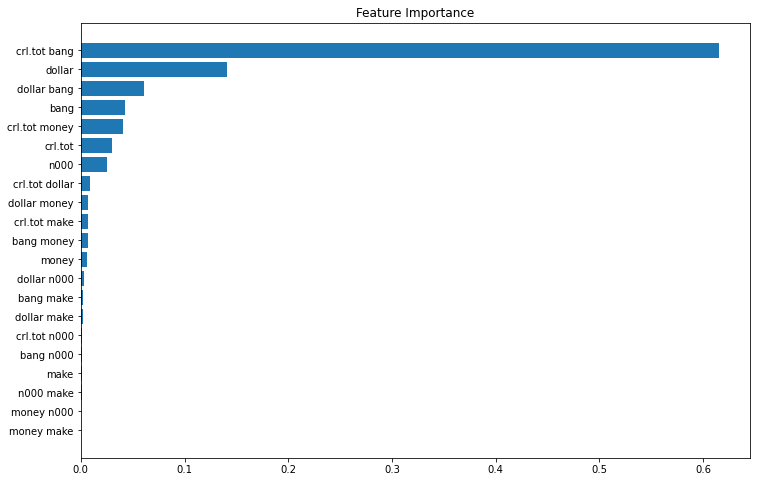

In [23]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')

plt.yticks(pos, np.array(list(X.columns))[sorted_idx])
plt.title('Feature Importance')

plt.show()

Ответ: dollar bang (Наплатформе очередной косяк и имя переменной принимается только в виде **"dollar_bang"**)

In [24]:
feature_importances_df = pd.DataFrame(np.reshape(feature_importance, (21,1)), index = list(X.columns), columns = ['importance']).sort_values(by = 'importance', ascending=False)

In [25]:
feature_importances_df.head()

,importance
crl.tot bang,0.614877
dollar,0.140770
dollar bang,0.060567
bang,0.042572
crl.tot money,0.040245


In [26]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
X.columns[sorted_idx][-3]

'dollar bang'

## Задание 6.4.4

In [27]:
from sklearn.model_selection import GridSearchCV

Теперь перейдем к подбору параметров в модели. Для этого в библиотеке scikit-learn есть метод GridSearchCV. Ему на вход подается модель, список параметров и способ оценивания. При запуске метода fit модель обучается со всеми возможными комбинациями параметров, лучшей комбинацией параметров становятся та, при которой значение метрики максимально.

Укажите в качестве estimator градиетный бустинг с параметрами по дефолту и random_state=42. В параметре scoring укажите 'accuracy', n_jobs=-1, cv=5.

Сетку параметров задайте такой:

In [28]:
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}

In [29]:
clf = GradientBoostingClassifier(
    random_state=42,
    #learning_rate=0.1,
    #n_estimators=100,
    #max_depth=3,
    #min_samples_split=2,
    #min_samples_leaf=1,
    #subsample=1,
    #max_features=None
    )

In [30]:
clf_GS = GridSearchCV(
    estimator = clf,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs=-1,
    cv=5)
clf_GS.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500,
                                          1750]},
             scoring='accuracy')

In [31]:
type(clf_GS.cv_results_) # Это словарик, в котором все результаты тестирования

dict

In [32]:
metrics_shown = ['mean_fit_time','mean_score_time','param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score', 'rank_test_score']

result_df = pd.DataFrame((clf_GS.cv_results_))
result_df[result_df['mean_test_score'] == result_df['mean_test_score'].max()][metrics_shown]

,mean_fit_time,mean_score_time,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,rank_test_score
29,8.726275,0.017816,0.01,1250,0.883696,0.012850,1
30,10.508548,0.021019,0.01,1500,0.883696,0.011224,1
31,12.491523,0.024623,0.01,1750,0.883696,0.009820,1


In [33]:
clf_GS.best_params_

{'learning_rate': 0.01, 'n_estimators': 1250}

In [34]:
clf_GS.refit_time_

7.886665105819702

Лучший резултат показали 3 набора параметров. При этом модели имеют явно различное время обучения

In [35]:
clf_GS.best_params_ 
# как и следовало ожидать GridSearch CV сначала выбрал наборы параметров с лучшим (наименьшим) rank_test_score,
# а затем с наилучшим (наименьшим) mean_score_time

{'learning_rate': 0.01, 'n_estimators': 1250}

8.014584064483643

In [36]:
# Ответ к заданию
round(result_df['mean_test_score'].max(),3)

0.884

In [37]:
round(clf_GS.best_score_,3) # Или так

0.884

## Задание 6.4.5

Подбор параметров — незаменимый инструмент при настройке моделей. Однако, если данных очень много, а модель сложная, то иногда имеет смысл ограничить количество параметров, которые вы хотите перебрать. Если модель с одним набором параметров обучается 30 минут, а вы хотите перебрать 10 таких наборов, то стоит приготовиться к пятичасовому ожиданию. Также стоит учитывать, что размер некоторых параметров влияет на время, потраченное на обучение моделей. Например, менее глубокие деревья учатся быстрее, чем глубокие.

При использовании GridSearchCV перебираются все возможные способы комбинации параметров. Сколько разных моделей (моделей градиентного бустинга с разными наборами параметров) обучилось в прошлом задании?

In [38]:
len(result_df)

48

In [39]:
clf_GS.cv_results_['mean_test_score'].shape

(48,)

In [40]:
def how_many_models(param_grid):
    '''
    Функция перебирает все параметры из сетки, которую мы задали
    и считает количество различных наборов, с которыми будут посчитаны модели.
    Во сути это просто перемножение количеств всех параметров
    '''
    result = 1
    for key in param_grid.keys():
        result*=len(param_grid[key])
    return result
how_many_models(param_grid)


48

Овет на задание: 48

## Задание 6.4.6

Теперь воспользуемся GridSearchCV для подбора максимальной глубины (max_depth). В качестве estimator используйте градиентный бустинг с раннеее подобранными параметрами и random_state=42. Переберите все значения max_depth от 5 до 15 включительно. В ответ запишите значение параметра, при котором точность максимальна.

In [41]:
clf = GradientBoostingClassifier(
    random_state=42,
    learning_rate=0.01,
    n_estimators=1250,
    #max_depth=3,
    #min_samples_split=2,
    #min_samples_leaf=1,
    #subsample=1,
    #max_features=None
    )

In [42]:
param_grid = {'max_depth':[x for x in range(5,16)]}

In [43]:
param_grid

{'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

In [44]:
clf_GS = GridSearchCV(
    estimator = clf,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs=-1,
    cv=5)
clf_GS.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                  n_estimators=1250,
                                                  random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
             scoring='accuracy')

In [45]:
clf_GS.best_params_
print('Ответ к заданию:', clf_GS.best_params_['max_depth'])

Ответ к заданию: 5


## Задание 6.4.7

In [46]:
from sklearn.tree import DecisionTreeClassifier

Может показаться, что, научившись запускать готовые фукнции из библиотек и настривать параметры, мы абсолютно готовы к работе. Однако на поле боя нас могут подстерегать еще опасности — legacy code, то есть код, написанный кем-то до вас. Может быть, его можно было бы и улучшить, но на нём уже столько всего надстроено, что переписывать всё практически невозможно.

А ещё часто будет возникать необходимость просто понять код коллеги или сделать code review (грубо говоря, это анализ кода на предмет ошибок и расхождения в стиле). Во всех этих ситуациях необходим навык быcтрого чтения кода.

Поэтому в качестве примера в этом задании мы предлагаем изучить код для реализации AdaBoost с нуля. Вам необходимо запустить эту функцию, но с дописанными строчками **(вычисление ошибки и веса алгоритма) на всех признаках **, получившихся после всех преобразований в предыдущем датасете (до разделения выборки на обучающую и тестовую). Параметр learning_rate возьмите равным 0.001, М = 10. В ответ запишите точность, округленную до трёх знаков после точки-разделителя.

In [47]:
# Соглано заданию нужно добавить:
#  - вычисление ошибки 
#  - вычисление веса алгоритма
#  на всех признаках в следующий код:

def AdaBoost_scratch(X,y, M=10, learning_rate = 1):
    # инициалиазция служебных переменных
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [],[],[],[],[]

    # инициализация весов
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    # цикл по длине М
    for m in range(M):   

        # обучим базовую модель и получим предсказание
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        # Маска для ошибок классификации
        incorrect = (y_predict != y)

        # Оцениваем ошибку
        estimator_error = (sample_weight[incorrect].sum()) / (sample_weight.sum()) 
        
        # Вычисляем вес нового алгоритма
        estimator_weight =  learning_rate*np.log((1-estimator_error)/estimator_error)

        # Получаем новые веса объектов
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        # Сохраяем результаты данной итерации
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    # Для удобства переведем в numpy.array   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Получим предсказания
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

In [48]:

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X, y, M=10, learning_rate=0.001)

Accuracy = 0.8228645946533363


# 6.5. Стекинг

https://dyakonov.org/2017/03/10/cтекинг-stacking-и-блендинг-blending/

# 6.6. Стекинг. Практика

In [49]:
# Dataset
from sklearn.datasets import load_digits
# EDA
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Split
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
# Other
from sklearn.base import clone
from scipy.stats.distributions import randint
from tqdm import tqdm
# Plot
from matplotlib import pyplot as plt
# Tunning
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

In [50]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', sep=',', header=None)[:10000]

features = list(range(0, 54))
target = 54

df = df[(df[target] == 1) | (df[target] == 2)]

# Split - разделим наш датасет на обучающую и условно тестовую выборку
cover_train, cover_test = train_test_split(df, test_size=0.5)

cover_X_train, cover_y_train = cover_train[features], cover_train[target]
cover_X_test, cover_y_test = cover_test[features], cover_test[target]

# Выполним стандартизацию признаков
scaler = StandardScaler()
cover_X_train = scaler.fit_transform(cover_X_train)
cover_X_test = scaler.transform(cover_X_test)

## Все задания выполняются на основе датасета:

In [51]:
dataset = load_digits()
X, y = dataset['data'], dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## Задание 6.6.1
В скринкасте мы разобрали схему генерации признаков в стекинге, когда для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке. Реализуйте схему, когда вместо этого производится агрегация ответов всех обученных на фолдах классификаторов на тестовой выборке при помощи усреднения.

Логика решения:
1) Создадим X_meta_test, заполним его нулями (по аналогии с X_meta_train);
2) Далее на каждом шаге, где мы обучаем folded_clf.fit (X_fold_train, y_fold_train) и его предсказания на X_fold_predict запихиваем в X_meta_train[predict_fold_index] добавим еще одну строку, где в X_meta_test будем добавлять предсказания вероятностей folded_clf на X_test. Их можно сразу складывать друг с другом или сохранить много массивов, тогда в конце их нужно будет все сложить, а потом делить на количество сплитов (количество массивов равно количеству сплитов в кросс - валидации);
3) После цикла останется только усреднить все эти массивы, это и будет наш X_meta_test.

### За основу нужно взять следующий код:

In [52]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """    Эта функция подсчитывает признаки для мета-классификатора.
           Они являются вероятностями классов при решении задачи многоклассовой классификации.
             :arg clf: классификатор    
             :args X_train, y_train: обучающая выборка    
             :arg X_test: признаки тестовой выборки    
             :arg cv: класс, генерирующий фолды (KFold)    
             :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок    """
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train), n_classes), dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)

    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)

    X_meta_test = meta_clf.predict_proba(X_test)

    return X_meta_train, X_meta_test

In [53]:
# Овет к заданию:
def compute_meta_feature_mean(clf, X_train, X_test, y_train, cv):

    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train), n_classes), dtype=np.float32)
    X_meta_test = np.zeros((len(X_test), n_classes), dtype=np.float32)
    
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
        X_meta_test+=folded_clf.predict_proba(X_test)
    
    X_meta_test = X_meta_test/cv.n_splits

    return X_meta_train, X_meta_test

## Для следующих заданий используйте этот код:

In [54]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [55]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [56]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test = y_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

### Подсказка
- Во всех случаях, когда модель принимает random_state — обязательно указывайте его равным 42
- На разных версиях sklearn ответы могут отличаться
- В задании может понадобиться, а может не понадобиться нормализация и это нужно проверить во время решения задания.

## Задание 6.6.2
Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
- логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимое количество итераций — 2000
- логистическая регрессия с L2-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — multinomial, максимальное допустимое количество итераций — 2000
- случайный лес из 300 деревьев
- градиентный бустинг из 200 деревьев

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [59]:
%%time
lg_L1 = LogisticRegression(
    random_state=42,
    penalty = 'l1',
    C = 0.001,
    solver='saga',
    multi_class='ovr',    
    max_iter = 2000,
    n_jobs = -1
)
lg_L2 = LogisticRegression(
    random_state=42,
    penalty = 'l2',
    C = 0.001,
    solver='saga',
    multi_class='multinomial',    
    max_iter = 2000,
    n_jobs = -1
) 
rf = RandomForestClassifier(
    random_state=42,
    n_estimators = 300,
    n_jobs = -1
)
gb = GradientBoostingClassifier(
    n_estimators=200
)

classifiers = [lg_L1, lg_L2, rf, gb]

meta_clf = LogisticRegression(
    random_state=42,
    solver='lbfgs',
    multi_class='auto',
    penalty = 'none',
    n_jobs = -1
)

X_train_meta, X_test_meta = generate_meta_features(classifiers, X_train, X_test, y_train, cv)


 75%|███████▌  | 3/4 [04:33<01:31, 91.01s/it]

100%|██████████| 4/4 [02:40<00:00, 40.24s/it]


In [60]:
%%time
compute_metric(clf = meta_clf, X_train=X_train_meta, y_train=y_train, X_test=X_test_meta, y_test = y_test)

Wall time: 1.59 s


0.980854

## Задание 6.6.3
Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
- случайный лес из 300 деревьев
- случайный лес из 200 экстремальных деревьев

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [61]:
%%time
# Базовый алгоритм 1
rf = RandomForestClassifier(
    random_state=42,
    n_estimators = 300,
    n_jobs = -1
)
# Базовый алгоритм 2
etc = ExtraTreesClassifier(
    random_state=42,
    n_estimators=200,
    n_jobs = -1
)

classifiers = [rf, etc]
# Метафункция
meta_clf = LogisticRegression(
    random_state=42,
    solver='lbfgs',
    multi_class='auto',
    penalty = 'none',
    n_jobs = -1
)

X_train_meta, X_test_meta = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

100%|██████████| 2/2 [00:12<00:00,  6.28s/it]Wall time: 12.6 s



In [62]:
compute_metric(clf = meta_clf, X_train=X_train_meta, y_train=y_train, X_test=X_test_meta, y_test = y_test)

0.982421

## Задание 6.6.4
Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
- метод ближайшего соседа (k-NN) со стандартными параметрами
- случайный лес из 300 экстремальных деревьев

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [63]:
%%time
# Базовый алгоритм 1
KN_clf = KNeighborsClassifier(n_jobs = -1)
# Базовый алгоритм 2
etc = ExtraTreesClassifier(
    random_state=42,
    n_estimators=300,
    n_jobs = -1
)

classifiers = [KN_clf, etc]
# Метафункция
meta_clf = LogisticRegression(
    random_state=42,
    solver='lbfgs',
    multi_class='auto',
    penalty = 'none',
    n_jobs = -1
)

X_train_meta, X_test_meta = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf = meta_clf, X_train=X_train_meta, y_train=y_train, X_test=X_test_meta, y_test = y_test)

100%|██████████| 2/2 [00:07<00:00,  3.99s/it]
Wall time: 8.94 s


0.989904

## Задание 6.6.5
Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
- логистическая регрессия с L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимоей количество итераций — 2000
- метод ближайшего соседа со стандартными параметрами
- случайный лес из 300 экстремальных деревьев
- AdaBoost со стандартными параметрами

Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric.

In [64]:
%%time
# Базовый алгоритм 1
lg_L1 = LogisticRegression(
    random_state=42,
    penalty = 'l1',
    C = 0.001,
    solver='saga',
    multi_class='ovr',    
    max_iter = 2000,
    n_jobs = -1
)
# Базовый алгоритм 2    
KN_clf = KNeighborsClassifier()
# Базовый алгоритм 3
etc = ExtraTreesClassifier(
        random_state=42,
        n_estimators=300,
    n_jobs = -1
)
# Базовый алгоритм 4
AB_clf = AdaBoostClassifier()

# Набор базовых алгоритмов
classifiers = [lg_L1, KN_clf, etc, AB_clf]
# Метафункция
meta_clf = LogisticRegression(
    random_state=42,
    solver='lbfgs',
    multi_class='auto',
    penalty = 'none',
    n_jobs = -1
)

X_train_meta, X_test_meta = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf = meta_clf, X_train=X_train_meta, y_train=y_train, X_test=X_test_meta, y_test = y_test)

100%|██████████| 4/4 [00:21<00:00,  5.48s/it]
Wall time: 23.1 s


0.987404

## Задание 6.6.6
Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
- случайный лес из 300 деревьев
- случайный лес из 300 экстремальных деревьев

Для генерации фолдов используйте класс StratifiedKFold, который позволяет делать так называемые стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов).

Для корректной работы необходимо подправить код в функции compute_meta_feature. Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — auto и солвером 'lbfgs'.
Посчитайте качество при помощи передачи новых признаков в функцию compute_metric. Количество фолдов = 10

In [65]:
%%time
# Базовый алгоритм 1
rf = RandomForestClassifier(
    random_state=42,
    n_estimators = 300
)
# Базовый алгоритм 2
etc = ExtraTreesClassifier(
        random_state=42,
        n_estimators=200
)

# Набор базовых алгоритмов
classifiers = [rf, etc]

# Метафункция
meta_clf = LogisticRegression(
    random_state=42,
    solver='lbfgs',
    multi_class='auto',
    penalty = 'none',
    n_jobs = -1
)

#cv = KFold(random_state=42, n_splits=10, shuffle=True)
cv = StratifiedKFold(random_state=42, n_splits=10)

def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train, y_train) # все изменения свелись к добавлению аргумента: y_train
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

X_train_meta, X_test_meta = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf = meta_clf, X_train=X_train_meta, y_train=y_train, X_test=X_test_meta, y_test = y_test)

100%|██████████| 2/2 [00:17<00:00,  8.68s/it]Wall time: 17.5 s



0.975562

## Задание 6.6.7
В предыдущей задаче измените 10 фолдов на 20. Укажите полученное качество.

In [66]:
%%time
cv = StratifiedKFold(random_state=42, n_splits=20)

X_train_meta, X_test_meta = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf = meta_clf, X_train=X_train_meta, y_train=y_train, X_test=X_test_meta, y_test = y_test)

100%|██████████| 2/2 [00:33<00:00, 16.94s/it]Wall time: 34 s



0.986861

## Задание 6.6.8
В предыдущей задаче укажите количество фолдов равным 5 и поменяйте мета-алгоритм на случайный лес со стандартными параметрами. Укажите полученное качество.

In [67]:
%%time
# Метафункция
meta_clf = RandomForestClassifier(
    random_state=42
)
cv = StratifiedKFold(random_state=42, n_splits=5)

X_train_meta, X_test_meta = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf = meta_clf, X_train=X_train_meta, y_train=y_train, X_test=X_test_meta, y_test = y_test)

100%|██████████| 2/2 [00:09<00:00,  4.55s/it]
Wall time: 9.38 s


0.981669

## Задание 6.6.9
В предыдущей задаче поменяйте мета-алгоритм на метод ближайших соседей (k-NN) со стандартными параметрами. Укажите полученное качество.

In [68]:
%%time
# Метафункция
meta_clf = KNeighborsClassifier()
cv = StratifiedKFold(random_state=42, n_splits=5)

X_train_meta, X_test_meta = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf = meta_clf, X_train=X_train_meta, y_train=y_train, X_test=X_test_meta, y_test = y_test)

100%|██████████| 2/2 [00:09<00:00,  4.52s/it]Wall time: 9.06 s



0.981669

## Задание 6.6.10
В предыдущей задаче поменяйте мета-алгоритм на градиентный бустинг со стандартными параметрами. Укажите полученное качество.

In [69]:
%%time
# Метафункция
meta_clf = GradientBoostingClassifier()

X_train_meta, X_test_meta = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf = meta_clf, X_train=X_train_meta, y_train=y_train, X_test=X_test_meta, y_test = y_test)

100%|██████████| 2/2 [00:09<00:00,  4.53s/it]
Wall time: 13.5 s


0.984243

## Задание 6.6.11
Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
- случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24
- случайный лес из 300 экстремальных деревьев

**Для генерации фолдов используйте класс StratifiedKFold**, который позволяет делать так называемые стратифицированные разбиения (в каждом фолде будет одинаковое соотношение классов).

Для генерации фолдов используйте класс StratifiedKFold и поправленный Вами ранее код в функции **compute_meta_feature**.

Выполните разбиение на 3 фолда.
Как мета-алгортм используйте случайный лес из 100 экстремальных деревьев. Посчитайте качество при помощи передачи новых признаков в функцию **compute_metric**.

In [70]:
%%time
# Базовый алгоритм 1
rf = RandomForestClassifier(
    random_state=42,
    n_estimators = 300
)
# Базовый алгоритм 2
etc = ExtraTreesClassifier(
        random_state=42,
        n_estimators=200
)

# Набор базовых алгоритмов
classifiers = [rf, etc]

# Метафункция
meta_clf = ExtraTreesClassifier(
        random_state=42,
        n_estimators=100
)
cv = StratifiedKFold(random_state=42, n_splits=3)
X_train_meta, X_test_meta = generate_meta_features(classifiers, X_train, X_test, y_train, cv)

compute_metric(clf = meta_clf, X_train=X_train_meta, y_train=y_train, X_test=X_test_meta, y_test = y_test)

100%|██████████| 2/2 [00:05<00:00,  2.87s/it]
Wall time: 5.92 s


0.985118

## Задание 6.6.12
Обучите на тренировочной выборке следующие алгоритмы:
- случайный лес из 300 деревьев, критерий Джини, максимальная глубина — 24
- случайный лес из 300 экстремальных деревьев
- логистическую регрессию со стандартными параметрами

Усредните их ответы на тестовой выборке и посчитайте качество аналогично функции compute_metric (F1-score с макро-усреднением, округленный до 6 знака).

In [71]:
%%time
# Базовый алгоритм 1
rf = RandomForestClassifier(
    random_state=42,
    n_estimators = 300,
    criterion = 'gini',
    max_depth = 24
)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
# Базовый алгоритм 2
etc = ExtraTreesClassifier(
        random_state=42,
        n_estimators=300
)
etc.fit(X_train,y_train)
y_pred += etc.predict(X_test)
# Базовый алгоритм 3
lg = LogisticRegression(
    random_state=42
)
lg.fit(X_train,y_train)
y_pred += lg.predict(X_test)
y_pred = y_pred/3
y_pred = np.round(y_pred)
np.round(f1_score(y_test, y_pred, average='macro'), 6)

Wall time: 2.1 s


0.960096

Ответ 0.960096 по сути верный, но платформой не принимается. 

Вариант для платформы ниже (ответ 0.965569). Вместо округления (round), нужно выполнить интование (int)

In [73]:
%%time
# Базовый алгоритм 1
rf = RandomForestClassifier(
    random_state=42,
    n_estimators = 300,
    criterion = 'gini',
    max_depth = 24
)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
# Базовый алгоритм 2
etc = ExtraTreesClassifier(
        random_state=42,
        n_estimators=300
)
etc.fit(X_train,y_train)
y_pred += etc.predict(X_test)
# Базовый алгоритм 3
lg = LogisticRegression(
    random_state=42
)
lg.fit(X_train,y_train)
y_pred += lg.predict(X_test)
y_pred = y_pred/3
y_pred = y_pred.astype(int)
np.round(f1_score(y_test, y_pred, average='macro'), 6)

Wall time: 2.1 s


0.965569

# 6.7. Готовимся к собеседованию

## Задание 6.7.1
В наборе данных 24 признака. Вы строите две модели: бэггинг над решающими деревьями и RandomForest. Пусть количество признаков, использующееся на одном разбиении для бэггинга над решающими деревьями равно А, для случайного леса — В.

Какое из следующих утверждений верно? Ответ: А больше или равно В

## Задание 6.7.2
При решении задачи регрессии случайные леса имеют больший разброс (variance) в предсказаниях по сравнению с бустингом над решающими деревьями (при условии, что обе модели оптимизированы, то есть параметры к ним подобраны).

Верно ли это утверждение? Ответ: Невозможно сказать, так как ответ зависит от данных верно

## Задание 6.7.3
В реальной жизни часто приходится работать с большими наборами данных. Для этого важно знать, какие модели могут обучаться быстрее благодаря возможности распараллелить вычисления (например, в предыдущих уроках вы уже выставляли параметр n_jonbs=-1 для этих целей).

В каких из моделей, перечисленных ниже, можно сделать вычисления (полностью или частично) параллельными? Ответ: Random Forest, XGBOOST (Extreme Gradient Boosting)

## Задание 6.7.4
На собеседовании могут попадаться и весьма хитрые вопросы. Может показаться, что вопрос ниже нацелен на «зубрёжку» документации. Однако с помощью подобных вопросов интервьюер проверяет ваши знания о том, что происходит внутри используемых вами алгоритмов.

При ответе на вопрос попробуйте вспомнить, как работают данные методы и нужен ли им этот параметр.

Задание для себя: попробуйте без подсказок перечислить, какие гиперпараметры вы бы настраивали для этих моделей. Обычно не требуется знание всех параметров наизусть, но самые основные (которые мы настраивали в этом и предыдущем модулях) помнить нужно.

Какие из приведенных ниже алгоритмов не используют темп обучения (learning rate) в качестве гиперпараметра? Ответ: ExtraTrees, RandomForest

## Задание 6.7.5
Попробуйте вспомнить ансамблевые алгоритмы, которые вы изучили в этом и предыдущем модулях. Выберите их из списка ниже: Ответ: RandomForest, GradientBoosting, AdaBoost 

## Задание 6.7.6
Выберите основные преимущества стекинга. Ответ: Более устойчивая к выбросам модель, Более точное предсказание

## Мои итоги и выводы:
1. Потрачено времени на изучение - 15 ч
2. Модуль следует повторить в течение месяца (сейчас в голове кашица)

In [74]:
## UPD 24/09/2020